<a href="https://colab.research.google.com/github/Loop3D/Kalgoorlie_fault_network/blob/main/report_files/01_Calculating%20the%20gradient%20constraint%20on%20the%20two%20types%20of%20fault%20information%20resulting%20from%20seismic%20and%20surface%20data%20-%20Ida%20and%20Kunanalling%20example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):
      !git clone https://github.com/Loop3D/Kalgoorlie_fault_network.git
      %cd Kalgoorlie_fault_network/report_files_faults
      !pip install git+https://github.com/Loop3D/LoopProjectFile.git
      !pip install git+https://github.com/Loop3D/map2loop-2.git
      !pip install git+https://github.com/Loop3D/LoopStructural
      !pip install lavavu-osmesa geopandas meshio rasterio owslib

else:
      print('Not running on CoLab, nothing to do')

Not running on CoLab, nothing to do


In [2]:
#downloads the dem as a tif file from the WCS server

from owslib.wcs import WebCoverageService as w

wcs = w(url="http://services.ga.gov.au/site_9/services/DEM_SRTM_1Second_over_Bathymetry_Topography/MapServer/WCSServer?", 
        version = "1.0.0")

test = wcs.getCoverage(identifier = "1", bbox = (214793, 6501886, 400412, 6653022), 
                      format="GeoTIFF", crs = 28351, width=200, height=200)

file = open("./data/dem.tif", 'wb')
file.write(test.read())
file.close()

# Imports

In [3]:
import geopandas as gpd
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer
from LoopStructural.modelling import ProcessInputData
from LoopStructural.utils import dtm_creator

path_seismic = r"./data/seismic"
path_shp = r"./data/gis"
path_DEM = r"./data/dem.tif"

In [4]:
# a function to darken the color of a hex list

def darken_color(color, amount=1.5):

    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

# 1. Import data

In [5]:
# open datasets and fusion seismic and surface data for Ida Fault

Ida_surface = gpd.read_file(os.path.join(path_shp, "Ida_pts_elevation.shp"))

Ida_seismic = gpd.read_file(os.path.join(path_seismic, "Ida_fault.shp"))

Ida_surface = pd.DataFrame({'X': Ida_surface.geometry.x, 
                        'Y': Ida_surface.geometry.y, 
                        'Z': Ida_surface.DEM_main_m})

Ida_surface['fault_name'] = "Ida Fault"

Ida_seismic = Ida_seismic[['X', 'Y', 'depth_minu', 'FAULT']]
Ida_seismic.columns = Ida_surface.columns

all_Ida_pts = pd.concat([Ida_surface, Ida_seismic]).reset_index(drop=True)

In [6]:
# open datasets and fusion seismic and surface data for Kunanalling Fault

Kunanalling_surface = gpd.read_file(os.path.join(path_shp, "Kunanalling_pts_elevation.shp"))
Kunanalling_surface = pd.DataFrame({'X': Kunanalling_surface.geometry.x, 
                               'Y': Kunanalling_surface.geometry.y, 
                               'Z': Kunanalling_surface.DEM_main})
Kunanalling_surface['fault_name'] = "Kunanalling Fault"

Kunanalling_seismic = gpd.read_file(os.path.join(path_seismic, "Kunanalling_fault.shp"))

Kunanalling_seismic = Kunanalling_seismic[['X', 'Y', 'depth_minu', 'FAULT']]
Kunanalling_seismic.columns = ['X', 'Y', 'Z', 'fault_name']
Kunanalling_seismic['fault_name'] = "Kunanalling Fault"

all_Kunanalling_pts = pd.concat([Kunanalling_seismic, Kunanalling_surface])

In [7]:
# plot both types of faults

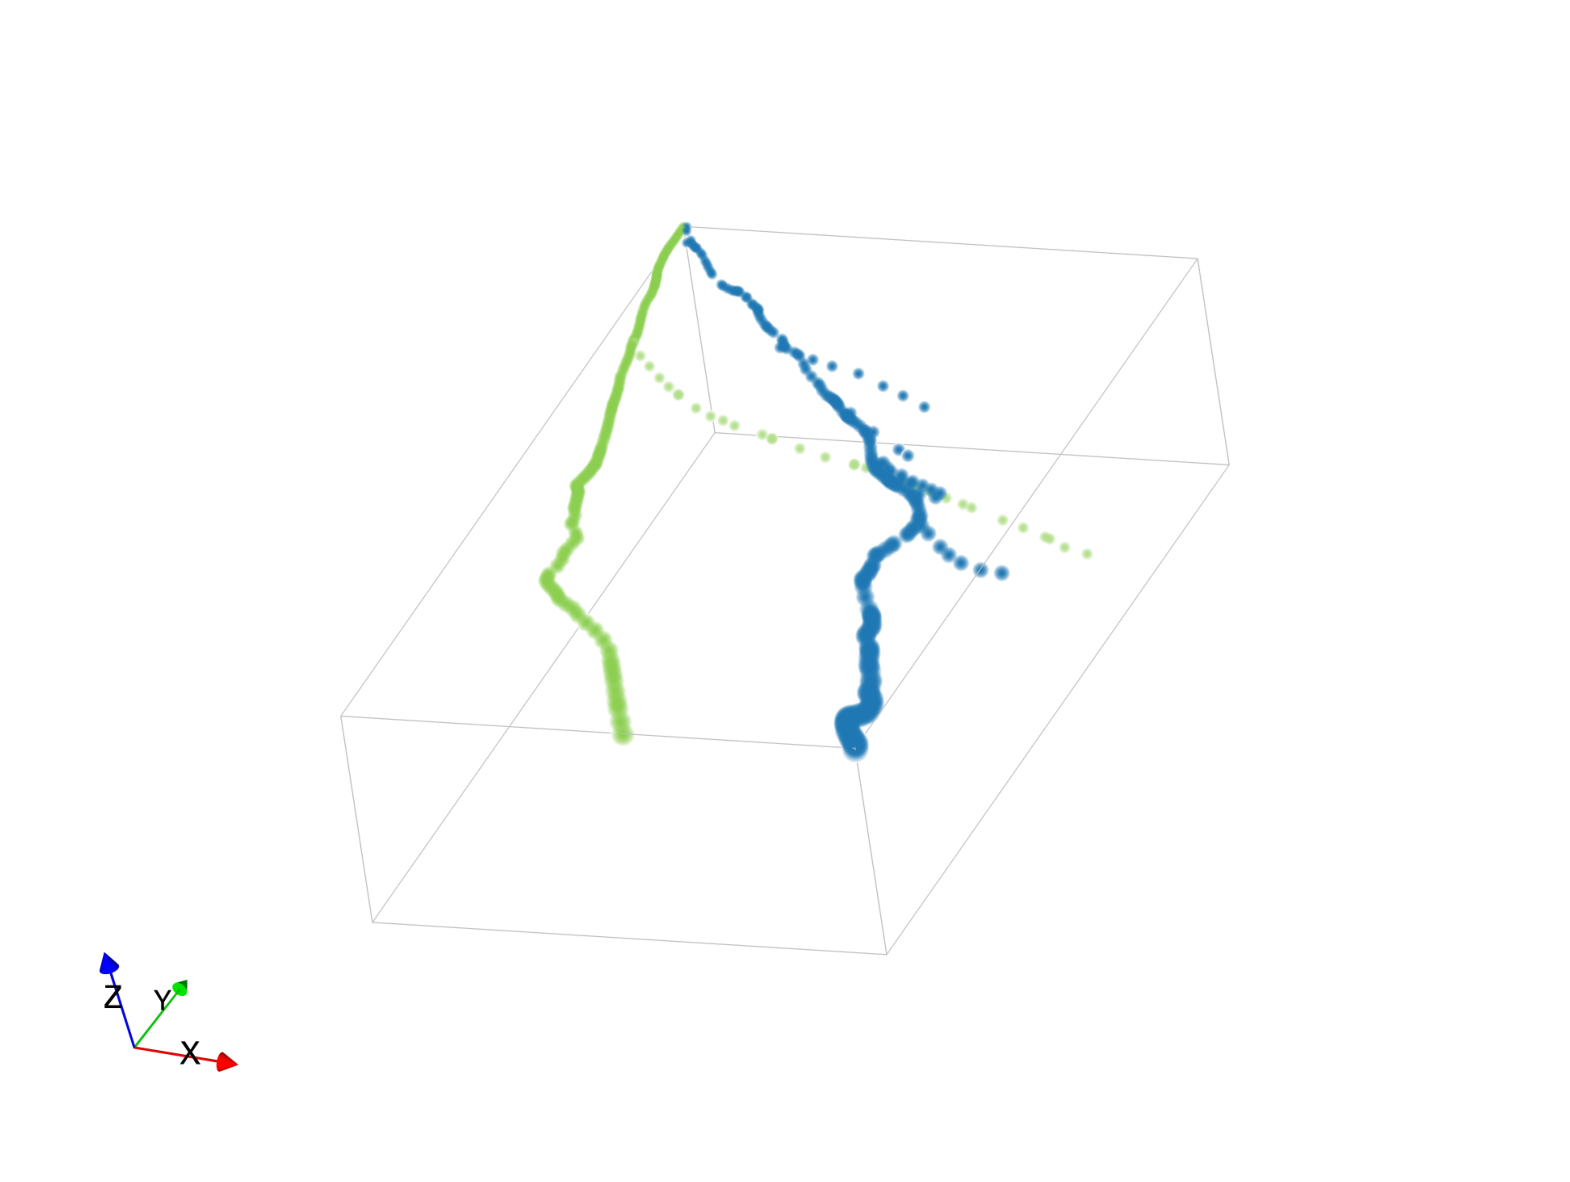

In [8]:
view = LavaVuModelViewer()

bbox = np.array([214794.5029269870719872, 6501887.2589999996125698, -40000, 
                 400411.4882275541312993, 6653021.2462467299774289, 5000]).reshape(2, 3)

view.bounding_box = bbox
view.nelements = 1e7
view.nsteps = [500,500,500]

view.add_points(Ida_seismic[['X', 'Y', 'Z']], name = 'Ida seismic', pointsize = 10, colour = '#b2df8a')
view.add_points(Ida_surface[['X', 'Y', 'Z']], name = 'Ida surface', pointsize = 10, colour = darken_color('#b2df8a'))

view.add_points(Kunanalling_seismic[['X', 'Y', 'Z']], name = 'Kunanalling seismic', pointsize = 10, colour = '#1f78b4')
view.add_points(Kunanalling_surface[['X', 'Y', 'Z']], name = 'Kunanalling surface', pointsize = 10, colour = '#1f78b4')

view.rotation = [-59.14857864379883, -21.383867263793945, -3.5806798934936523]

plt.figure(figsize = (20,20))
plt.imshow(view.image_array(resolution = (1920, 1440)))
plt.axis('off');
plt.savefig('./assets/two_types.jpeg', dpi = 500)

# Modelling Ida Fault
## Case 1 - solving for the 3D linear least squares' coefficients

In [9]:
# solve the 3D linear least squares

gs = []

tmpA = []
tmpB = []

xs = Ida_seismic['X'].to_numpy()
ys = Ida_seismic['Y'].to_numpy()
zs = Ida_seismic['Z'].to_numpy()

meanX = Ida_surface['X'].mean()
meanY = Ida_surface['Y'].mean()
meanZ = zs.mean()

for j in range(len(xs)):
    tmpA.append([xs[j], ys[j], 1])
    tmpB.append(zs[j])

b = np.matrix(tmpB).T
A = np.matrix(tmpA)

fit = (A.T * A).I * A.T * b

# find the norms
kdr = pd.DataFrame({'gx': [fit[0,0]], 
                  'gy': fit[1,0], 
                  'gz': -1})

kdr /= np.linalg.norm(kdr)

gs.append(['Ida Fault', meanX, meanY, meanZ, 
           kdr['gx'][0], 
           kdr['gy'][0],
           kdr['gz'][0]])

In [10]:
fit

matrix([[-7.12647975e-01],
        [ 2.58932256e+00],
        [-1.69389413e+07]])

In [11]:
ori = pd.DataFrame(gs, columns = ['fault_name', 'X', 'Y', 'Z', 'gx', 'gy', 'gz'])
ori

,fault_name,X,Y,Z,gx,gy,gz
0,Ida Fault,281825.12709,6.595975e+06,-19118.905,-0.248679,0.903545,-0.34895


In [12]:
origin = [214794.5029269870719872, 6501887.2589999996125698, -40000]
maximum = [400411.4882275541312993, 6653021.2462467299774289, 5000]

processor = ProcessInputData(fault_locations = all_Ida_pts,
                             fault_orientations = ori,
                             origin=origin,
                             maximum=maximum
                            )

                This will result in only a fault surface, no displacement on older features


In [13]:
model = GeologicalModel(origin, maximum)

model.data = processor.data

model.create_and_add_fault('Ida Fault', 
                           displacement = 5, 
                           nelements=1e4, 
                           force_mesh_geometry = True, 
                           npw=5, cpw = 0.05)

model.update(verbose = True)

Updating geological model. There are: 
 3                     geological features that need to be interpolated



  0%|          | 0/3 [00:00<?, ?it/s]

Model update took: 4.9230451583862305 seconds


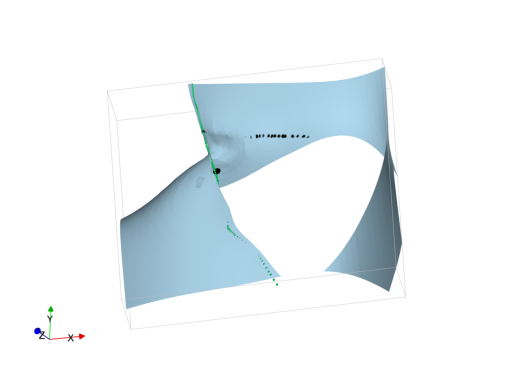

In [14]:
view = LavaVuModelViewer(model)

view.add_isosurface(model['Ida Fault'], colours = ['#a6cee3'], value = 0)
view.add_data(model['Ida Fault'][0])
view.add_points(Ida_seismic[['X', 'Y', 'Z']], name = 'test', pointsize = 10)

view.zmax = 0.92
# view.interactive()
view.rotation = [-26.88098907470703, -5.752695083618164, 6.755039215087891]
# view.display()

plt.imshow(view.image_array(resolution = (1920, 1440)))
plt.axis('off');
plt.savefig('./assets/Ida_3dleastsquares.jpeg', dpi = 500)

# Modelling Ida Fault
## Case 2 - Calculating the norm of the gradients constraints for x, y and z

In [15]:
# find the strike

tangent_xy = (Ida_surface[["X", "Y", "Z"]].to_numpy()[0, :] - Ida_surface[["X", "Y", "Z"]].to_numpy()[-1, :])
norm_xy = tangent_xy / np.linalg.norm(tangent_xy)

#check if the norm equals to unit
# np.linalg.norm(norm_xy)

# find the maximum and minimum Z's
max_xyz = Ida_seismic[Ida_seismic['Z']==Ida_seismic['Z'].max()][['X', 'Y', 'Z']].to_numpy()
min_xyz = Ida_seismic[Ida_seismic['Z']==Ida_seismic['Z'].min()][['X', 'Y', 'Z']].to_numpy()

tangent_z1 = (max_xyz - min_xyz)
norm_z = tangent_z1 / np.linalg.norm(tangent_z1) # unit vector

CP = np.cross(norm_xy, norm_z)

In [16]:
ori_I = pd.DataFrame(CP)
ori_I['fault_name'] = "Ida Fault"
ori_I.columns = ['gx', 'gy', 'gz', 'fault_name']

ori_I['X'] = Ida_surface['X'].mean()
ori_I['Y'] = Ida_surface['Y'].mean()
ori_I['Z'] = Ida_seismic['Z'].mean()

ori_I

,gx,gy,gz,fault_name,X,Y,Z
0,0.455672,0.129275,0.865917,Ida Fault,281825.12709,6.595975e+06,-19118.905


## Model in LoopStructural

In [17]:
# define the origin and maximum of the model

origin = [214794.5029269870719872, 6501887.2589999996125698, -40000]
maximum = [400411.4882275541312993, 6653021.2462467299774289, 5000]

In [18]:
processor = ProcessInputData(fault_locations = all_Ida_pts,
                             fault_orientations = ori_I,
                             origin=origin,
                             maximum=maximum
                            )

                This will result in only a fault surface, no displacement on older features


In [19]:
model = GeologicalModel(origin, maximum)

model.data = processor.data

model.create_and_add_fault('Ida Fault', 
                           displacement = 5, 
                           nelements=1e4, 
                           force_mesh_geometry = True, 
                           npw=5, cpw = 0.05)

model.update(verbose = True)

Updating geological model. There are: 
 3                     geological features that need to be interpolated



  0%|          | 0/3 [00:00<?, ?it/s]

Model update took: 7.885993003845215 seconds


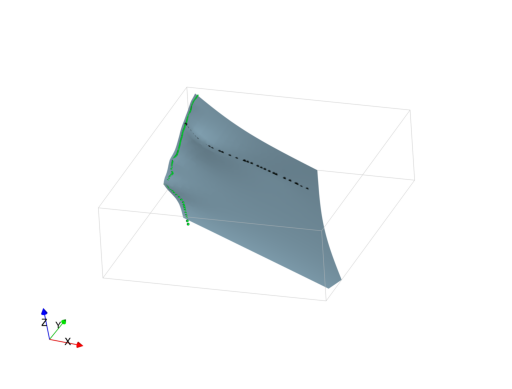

In [20]:
view = LavaVuModelViewer(model)

view.add_isosurface(model['Ida Fault'], colours = ['#a6cee3'], value = 0)
view.add_data(model['Ida Fault'][0])
view.add_points(Ida_seismic[['X', 'Y', 'Z']], name = 'test', pointsize = 10)

view.zmax = 0.92
view.rotation = [-61.811073303222656, -18.319021224975586, -5.86142635345459]
# view.interactive()
# view.display()

plt.imshow(view.image_array(resolution = (1920, 1440)))
plt.axis('off');
plt.savefig('./assets/Ida_tangent.jpeg', dpi = 300)

# Modelling Kunanalling Fault
## Calculating the norm of the gradients constraints for x, y and z solving the constraints for a 3D least squares

In [21]:
# solve the 3D least squares

tmpA = []
tmpB = []

xs = Kunanalling_seismic['X'].to_numpy()
ys = Kunanalling_seismic['Y'].to_numpy()
zs = Kunanalling_seismic['Z'].to_numpy()

for j in range(len(xs)):
    tmpA.append([xs[j], ys[j], 1])
    tmpB.append(zs[j])

b = np.matrix(tmpB).T
A = np.matrix(tmpA)

fit = (A.T * A).I * A.T * b

kdr = pd.DataFrame({'gx': [fit[0, 0]], 'gy': fit[1, 0], 'gz': -1})

kdr /= np.linalg.norm(kdr)

meanX = Kunanalling_surface['X'].mean()
meanY = Kunanalling_surface['Y'].mean()
meanZ = zs.mean()

gs = []
gs.append(['Kunanalling Fault', meanX, meanY, meanZ, 
           kdr['gx'][0], 
           kdr['gy'][0],
           kdr['gz'][0]])

ori_K = pd.DataFrame(gs, columns = ['fault_name', 'X', 'Y', 'Z', 'gx', 'gy', 'gz'])

ori_K

,fault_name,X,Y,Z,gx,gy,gz
0,Kunanalling Fault,325759.559201,6.574631e+06,-4068.768056,-0.459887,-0.336245,-0.821853


In [22]:
# Inititate the model

updated_data = pd.concat([Kunanalling_seismic, Kunanalling_surface])

origin = [214794.5029269870719872, 6501887.2589999996125698, -40000]
maximum = [400411.4882275541312993, 6653021.2462467299774289, 5000]

In [23]:
processor = ProcessInputData(fault_locations = updated_data, 
                              fault_orientations = ori_K,
                              origin = origin, 
                              maximum = maximum)

                This will result in only a fault surface, no displacement on older features


In [24]:
model = GeologicalModel(origin, maximum)

model.data = processor.data

model.create_and_add_fault('Kunanalling Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                          cpw = 0.05, npw = 5
                          )
model.update()

  0%|          | 0/3 [00:00<?, ?it/s]

Object exists: Kunanalling Fault_value_cp
Object exists: Kunanalling Fault_value_cp


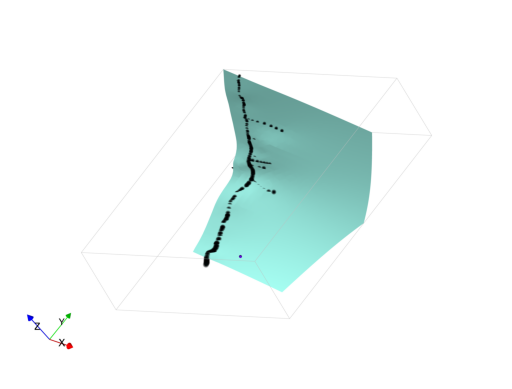

In [25]:
view = LavaVuModelViewer(model)

view.add_isosurface(model['Kunanalling Fault'], colours = ['#a6fff3'], value = 0)

view.add_points(Kunanalling_seismic[['X', 'Y', 'Z']], pointsize = 10, name = 'Kunanalling_seismic_pts')
view.add_points(Kunanalling_surface[['X', 'Y', 'Z']], pointsize = 10, name = 'Kunanalling_surface_pts')
view.add_data(model['Kunanalling Fault'], vectors = True)

view.rotation = [-45.39636993408203, -43.501014709472656, -2.904033660888672]
# view.display()
# view.interactive()

plt.imshow(view.image_array(resolution = (1920, 1440)))
plt.axis('off');
plt.savefig('./assets/Kunanalling_3dleastsquares.jpeg', dpi = 500)

# Add Ida and Kunanalling faults in the same model

In [26]:
updated_data = pd.concat([all_Ida_pts, all_Kunanalling_pts]).reset_index(drop=True)
updated_oris = pd.concat([ori_K, ori_I])

processor = ProcessInputData(fault_locations = updated_data, 
                              fault_orientations = updated_oris,
                              origin = origin, maximum = maximum)

                This will result in only a fault surface, no displacement on older features


In [29]:
model = GeologicalModel(origin, maximum)

model.data = processor.data

model.dtm = dtm_creator.create_dtm_with_rasterio(path_DEM) 

model.create_and_add_fault('Ida Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                          npw = 5, cpw = 0.05)

model.create_and_add_fault('Kunanalling Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                          npw = 5, cpw = 0.05)

model.update(verbose = True)

Updating geological model. There are: 
 6                     geological features that need to be interpolated



  0%|          | 0/6 [00:00<?, ?it/s]

Model update took: 13.357961893081665 seconds



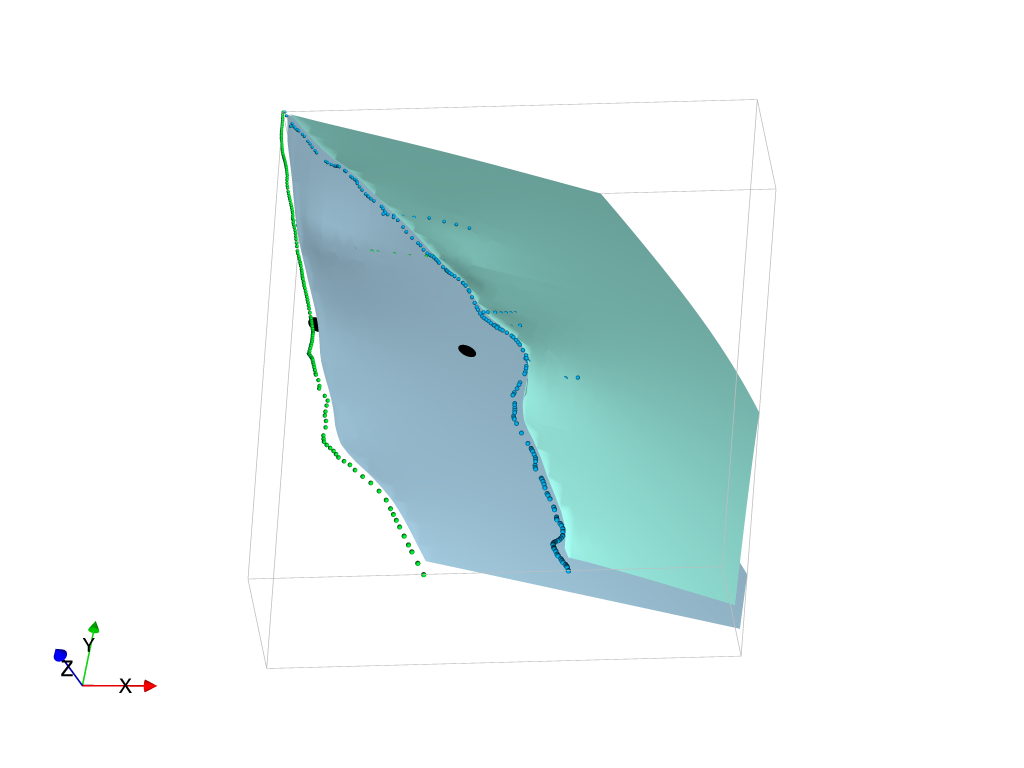

In [30]:
view = LavaVuModelViewer(model)

view.add_isosurface(model['Ida Fault'], colours = ['#a6cee3'], value = 0)
view.add_isosurface(model['Kunanalling Fault'], colours = ['#a6fff3'], value = 0)
view.add_data(model['Ida Fault'][0])
view.add_data(model['Kunanalling Fault'][0])

view.rotation = [-36.67970275878906, -7.796771049499512, 1.499132513999939]
view.display()
# view.interactive()

In [28]:
updated_data.reset_index(drop=True).to_csv("./data/LoopStructural_data/updated_data.csv", index=False)
updated_oris.reset_index(drop=True).to_csv("./data/LoopStructural_data/updated_oris.csv", index=False)